In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
is_v2 = True

#### **Traitement de la base de donnée**

In [93]:
# Load the dataset
df = pd.read_csv('dataset/telco_dataset.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [94]:
def audit(df):
    return pd.DataFrame({
        "dtype": df.dtypes,
        "missing": df.isna().sum(),
        "missing_%": (df.isna().mean() * 100).round(2),
        "unique": df.nunique(),
        "sample": df.iloc[0]
    })
audit(df)

,dtype,missing,missing_%,unique,sample
customerID,object,0,0.0,7043,7590-VHVEG
gender,object,0,0.0,2,Female
SeniorCitizen,int64,0,0.0,2,0
Partner,object,0,0.0,2,Yes
Dependents,object,0,0.0,2,No
tenure,int64,0,0.0,73,1
PhoneService,object,0,0.0,2,No
MultipleLines,object,0,0.0,3,No phone service
InternetService,object,0,0.0,3,DSL
OnlineSecurity,object,0,0.0,3,No


In [95]:
#on transforme les variables yes / no en binaire 
binary_cols = ["gender",'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
mapping = {'Yes': 1, 'No': 0, 'Female': 1, 'Male': 0}
for col in binary_cols:
    df[col] = df[col].str.capitalize().map(mapping)    
df[binary_cols].head()

,gender,Partner,Dependents,PhoneService,PaperlessBilling,Churn
0,1,1,0,0,1,0
1,0,0,0,1,0,0
2,0,0,0,1,1,1
3,0,0,0,0,0,0
4,1,0,0,1,1,1


In [96]:
# Encodage Ordinal pour le Contrat (Il y a une notion d'ordre/durée)
dummy_cols = []
if(is_v2) :
    contract_mapping = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
    df['Contract'] = df['Contract'].map(contract_mapping)
    dummy_cols = ["MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport","StreamingTV" ,"StreamingMovies", "PaymentMethod"]
    df = pd.get_dummies(df, columns= dummy_cols,dtype=int, drop_first=True)
else :
    dummy_cols = ["MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport","StreamingTV" ,"StreamingMovies", "Contract", "PaymentMethod"]
    df = pd.get_dummies(df, columns= dummy_cols,dtype=int)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,Contract,PaperlessBilling,MonthlyCharges,...,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,0,1,0,1,0,0,1,29.85,...,0,0,0,0,0,0,0,0,1,0
1,5575-GNVDE,0,0,0,0,34,1,1,0,56.95,...,1,0,0,0,0,0,0,0,0,1
2,3668-QPYBK,0,0,0,0,2,1,0,1,53.85,...,0,0,0,0,0,0,0,0,0,1
3,7795-CFOCW,0,0,0,0,45,0,1,0,42.30,...,1,0,1,0,0,0,0,0,0,0
4,9237-HQITU,1,0,0,0,2,1,0,1,70.70,...,0,0,0,0,0,0,0,0,1,0


In [97]:
df.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,Contract,PaperlessBilling,MonthlyCharges,Churn,...,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.495244,0.162147,0.483033,0.299588,32.371149,0.903166,0.690473,0.592219,64.761692,0.265370,...,0.343888,0.216669,0.290217,0.216669,0.384353,0.216669,0.387903,0.216101,0.335794,0.228880
std,0.500013,0.368612,0.499748,0.458110,24.559481,0.295752,0.833755,0.491457,30.090047,0.441561,...,0.475038,0.412004,0.453895,0.412004,0.486477,0.412004,0.487307,0.411613,0.472301,0.420141
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,35.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,1.000000,70.350000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,89.850000,1.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,1.000000,118.750000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [98]:
audit(df)

,dtype,missing,missing_%,unique,sample
customerID,object,0,0.0,7043,7590-VHVEG
gender,int64,0,0.0,2,1
SeniorCitizen,int64,0,0.0,2,0
Partner,int64,0,0.0,2,1
Dependents,int64,0,0.0,2,0
tenure,int64,0,0.0,73,1
PhoneService,int64,0,0.0,2,0
Contract,int64,0,0.0,3,0
PaperlessBilling,int64,0,0.0,2,1
MonthlyCharges,float64,0,0.0,1585,29.85


on remarque que totalcharge est de type objext, certain champs sont vide 

In [99]:
# Conversion en numérique, les espaces deviennent des NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [100]:
df.isna().sum()

customerID                                0
gender                                    0
SeniorCitizen                             0
Partner                                   0
Dependents                                0
tenure                                    0
PhoneService                              0
Contract                                  0
PaperlessBilling                          0
MonthlyCharges                            0
TotalCharges                             11
Churn                                     0
MultipleLines_No phone service            0
MultipleLines_Yes                         0
InternetService_Fiber optic               0
InternetService_No                        0
OnlineSecurity_No internet service        0
OnlineSecurity_Yes                        0
OnlineBackup_No internet service          0
OnlineBackup_Yes                          0
DeviceProtection_No internet service      0
DeviceProtection_Yes                      0
TechSupport_No internet service 

In [101]:
# Traitement de la colonne 'TotalCharges'
# Remplissage des NaN par 0 (car ce sont des nouveaux clients n'ayant rien payé)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [102]:
df.drop(columns=['customerID'], inplace=True)

In [103]:
if(is_v2):
    df.to_csv("dataset/cleaned_dataset_v2.csv")
else :
    df.to_csv("dataset/cleaned_dataset.csv")

#### **Analyse descriptive et visualtion de la base de donnée**

In [104]:
base=pd.read_csv("dataset/cleaned_dataset.csv")
base.head()

,Unnamed: 0,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,0,1,29.85,29.85,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,0,34,1,0,56.95,1889.50,...,1,0,0,0,1,0,0,0,0,1
2,2,0,0,0,0,2,1,1,53.85,108.15,...,1,0,0,1,0,0,0,0,0,1
3,3,0,0,0,0,45,0,0,42.30,1840.75,...,1,0,0,0,1,0,1,0,0,0
4,4,1,0,0,0,2,1,1,70.70,151.65,...,1,0,0,1,0,0,0,0,1,0


##### Analyse sur les variables quantitatives 

In [105]:
# On sélectionne les variables numériques
num_vars = ["tenure", "MonthlyCharges", "TotalCharges"]
print(base[num_vars].describe())

            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


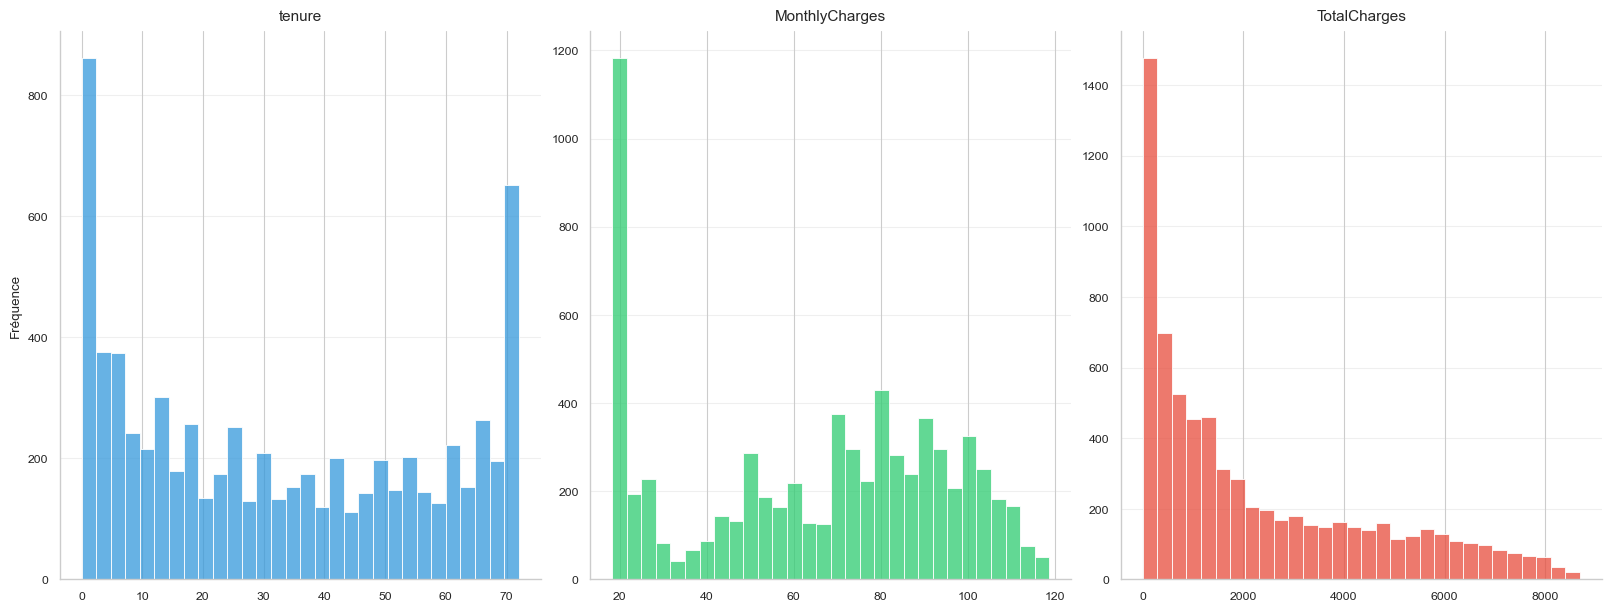

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid",context="paper")
plt.rcParams["font.family"] = "sans-serif"

palette = ["#3498db", "#2ecc71", "#e74c3c"]
num_vars = ["tenure", "MonthlyCharges", "TotalCharges"]
fig, axes = plt.subplots(1, 3,figsize=(16, 6),constrained_layout=True)
for i, col in enumerate(num_vars):
    sns.histplot(data=base,x=col,bins=30,ax=axes[i],color=palette[i],edgecolor="white",linewidth=0.6)
    axes[i].set_title(col, fontsize=11, pad=8)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Fréquence" if i == 0 else "")
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)
    axes[i].grid(axis="y", alpha=0.3)
plt.show()


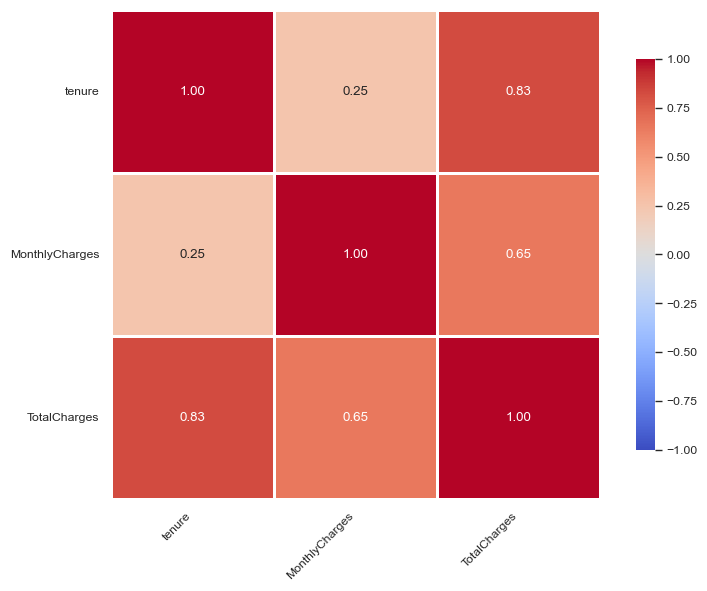

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Calcul de la matrice de corrélation
corr_matrix = base[num_vars].corr()
fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
sns.heatmap(corr_matrix,annot=True,fmt='.2f',cmap="coolwarm",center=0,square=True,linewidths=1,linecolor='white',cbar_kws={'shrink': 0.8},ax=ax,vmin=-1,vmax=1)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### Analyse sur les variables qualitatives

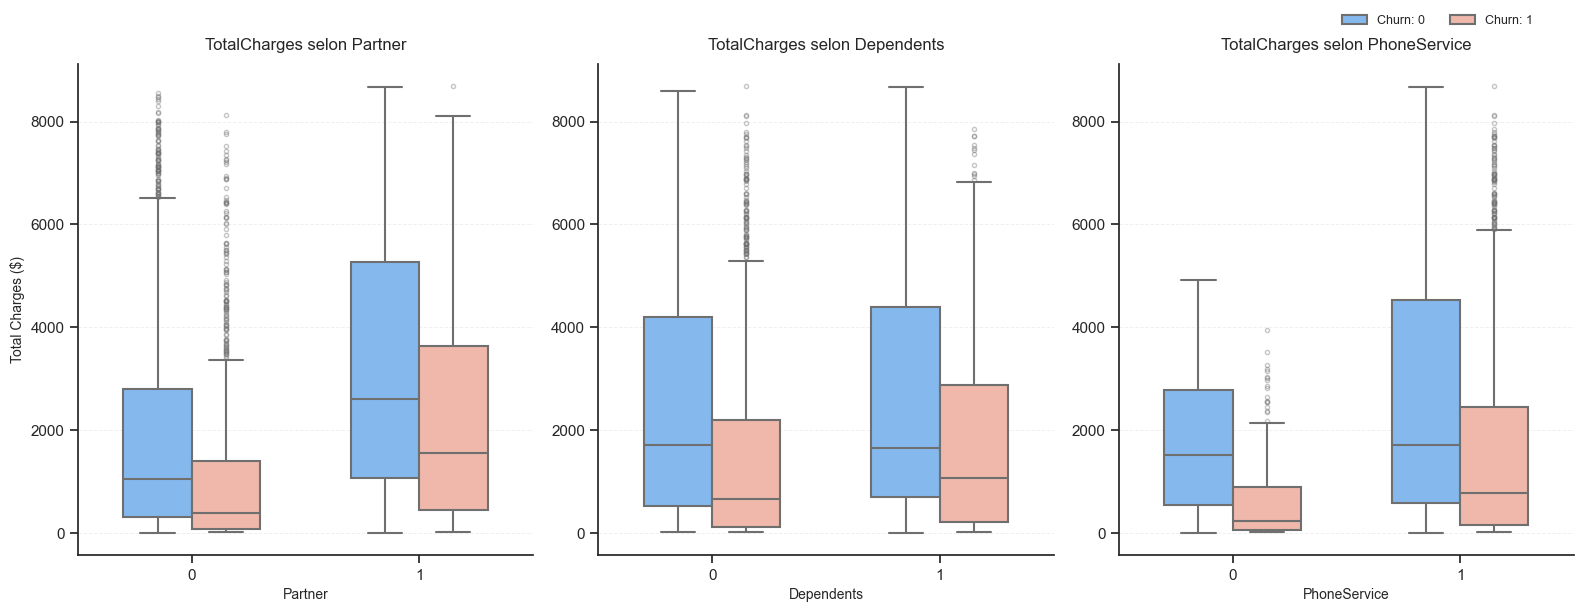

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables binaires à analyser
binary_vars = ["Partner", "Dependents", "PhoneService"]
sns.set_theme(style="ticks", context="notebook")
plt.rcParams['font.family'] = 'sans-serif'
palette = ["#74b9ff", "#fab1a0"]
# Création de la grille de boxplots
fig, axes = plt.subplots(1, 3, figsize=(16, 6), facecolor='white')
for i, col in enumerate(binary_vars):
    sns.boxplot(x=col,y="TotalCharges",hue="Churn",data=df,palette=palette,ax=axes[i],width=0.6,linewidth=1.5,fliersize=3,flierprops={'alpha': 0.4})
    axes[i].set_title(f'TotalCharges selon {col}', fontsize=12, pad=10)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Total Charges ($)' if i == 0 else '', fontsize=10)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)
    axes[i].set_axisbelow(True)
    if axes[i].get_legend():
        axes[i].get_legend().remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Churn: 0', 'Churn: 1'], loc="lower right",frameon=False,ncol=2,fontsize=9,bbox_to_anchor=(0.97, 0.97))
plt.tight_layout()
plt.show()

### Création d'un dataset orienté tenure 

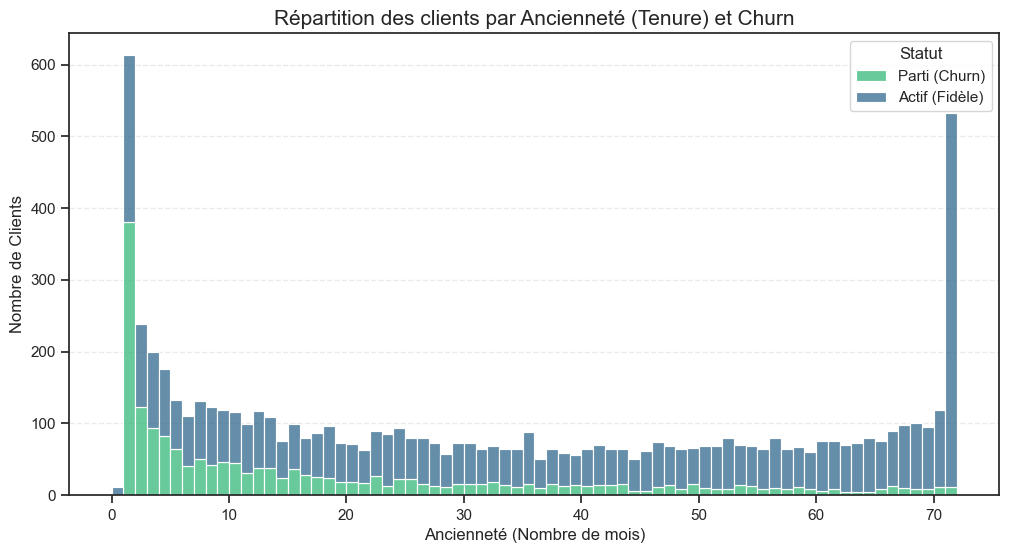

In [109]:

df = pd.read_csv('dataset/cleaned_dataset_v2.csv')

plt.figure(figsize=(12, 6))

sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', bins=72, palette='viridis')

plt.title('Répartition des clients par Ancienneté (Tenure) et Churn', fontsize=15)
plt.xlabel('Ancienneté (Nombre de mois)', fontsize=12)
plt.ylabel('Nombre de Clients', fontsize=12)
plt.legend(title='Statut', labels=['Parti (Churn)', 'Actif (Fidèle)'])
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.show()

In [110]:

df = pd.read_csv('dataset/cleaned_dataset_v2.csv')


def categoriser_churn(row):
    if row['Churn'] == 0:
        return 'Active'
    else:
        borne_sup = int(np.ceil(row['tenure'] / 3) * 3)
        if borne_sup == 0: borne_sup = 3 
        borne_inf = borne_sup - 3
        return f"{borne_inf}-{borne_sup} mois"

df['Churn_Period'] = df.apply(categoriser_churn, axis=1)

df.to_csv('dataset/dataset_churn_3_mois.csv', index=False)

print(df[['tenure', 'Churn', 'Churn_Period']].head())

   tenure  Churn Churn_Period
0       1      0       Active
1      34      0       Active
2       2      1     0-3 mois
3      45      0       Active
4       2      1     0-3 mois


C:\Users\sppre\AppData\Local\Temp\ipykernel_13096\4273121115.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=churners_only, x='Churn_Period', order=ordre_labels, palette='viridis')


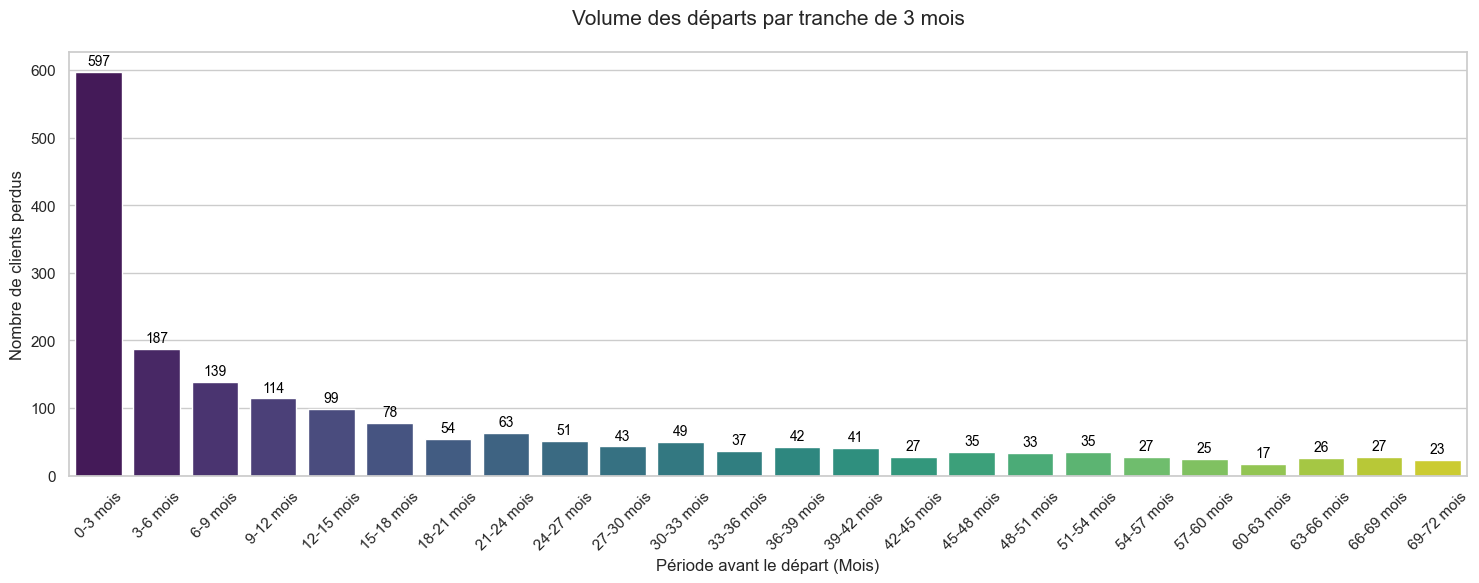

C:\Users\sppre\AppData\Local\Temp\ipykernel_13096\4273121115.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn_Period', y='MonthlyCharges', order=ordre_complet, palette='coolwarm')


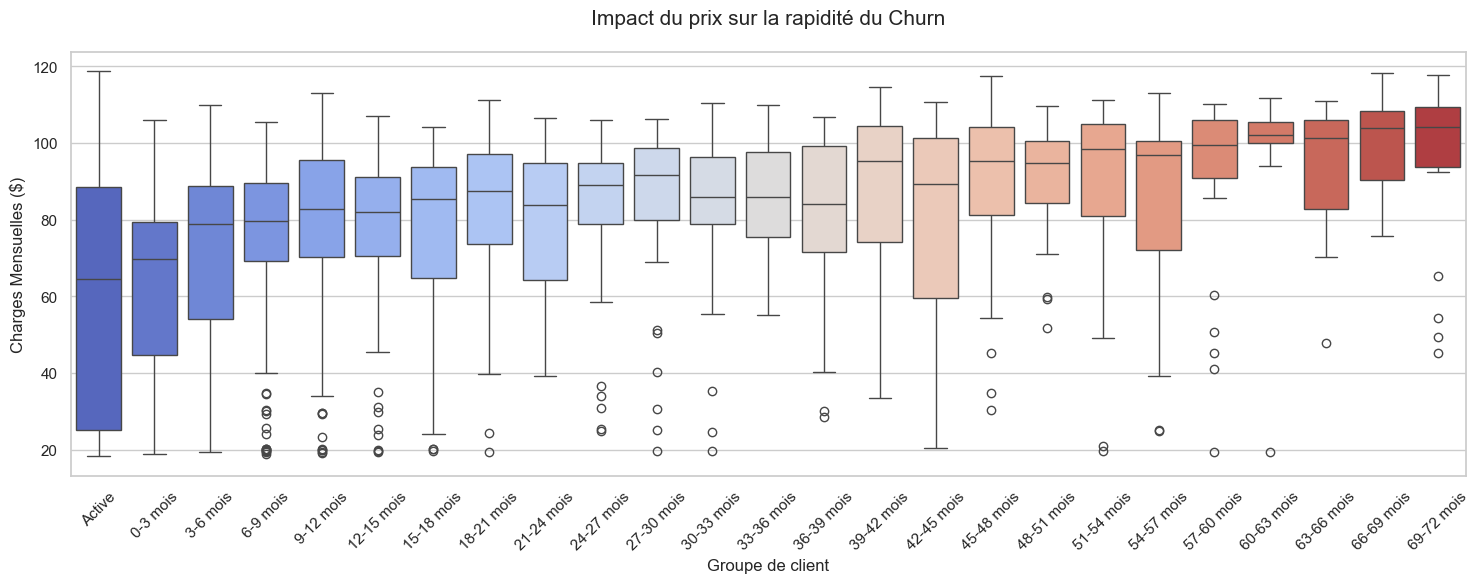

In [111]:


churners_only = df[df['Churn_Period'] != 'Active'].copy()
def extraire_ordre(label):
    return int(label.split('-')[0])
ordre_labels = sorted(churners_only['Churn_Period'].unique(), key=extraire_ordre)

# Configurer le style général
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15, 6))
ax = sns.countplot(data=churners_only, x='Churn_Period', order=ordre_labels, palette='viridis')

# Ajout des étiquettes de données au-dessus des barres
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Volume des départs par tranche de 3 mois', fontsize=15, pad=20)
plt.xlabel('Période avant le départ (Mois)', fontsize=12)
plt.ylabel('Nombre de clients perdus', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
# On ajoute 'Active' au début de l'ordre pour comparer
ordre_complet = ['Active'] + ordre_labels

sns.boxplot(data=df, x='Churn_Period', y='MonthlyCharges', order=ordre_complet, palette='coolwarm')

plt.title('Impact du prix sur la rapidité du Churn', fontsize=15, pad=20)
plt.xlabel('Groupe de client', fontsize=12)
plt.ylabel('Charges Mensuelles ($)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [112]:

df = pd.read_csv('dataset/cleaned_dataset_v2.csv')

#  On travaille uniquement sur ceux qui ont churné pour définir les seuils
churners = df[df['Churn'] == 1].copy()

#  On crée 4 catégories d'égale importance (quintiles)
churners['Churn_Period'], bins = pd.qcut(churners['tenure'], q=4, retbins=True, duplicates='drop')

# On nettoie les labels pour qu'ils soient lisibles (ex: "0-2 mois")
bins = bins.astype(int)
labels = [f"{bins[i]}-{bins[i+1]} mois" for i in range(len(bins)-1)]

def categoriser_equilibre(row):
    if row['Churn'] == 0:
        return 'Active'
    else:
        # On replace le tenure dans la bonne tranche définie par les quintiles
        for i in range(len(bins)-1):
            if bins[i] <= row['tenure'] <= bins[i+1]:
                return labels[i]
        return labels[-1]

df['Churn_Period'] = df.apply(categoriser_equilibre, axis=1)

print("Distribution des classes (Équilibrée) :")
print(df['Churn_Period'].value_counts())
# Définir l'ordre logique
mapping = {
    'Active': 0,
    '1-2 mois': 1,
    '2-10 mois': 2,
    '10-29 mois': 3, 
    '29-72 mois': 4
}

# Appliquer le mapping
df['Churn_Encoded'] = df['Churn_Period'].map(mapping)

# Sauvegarde
df.to_csv('dataset/dataset_churn_equilibre.csv', index=False)

Distribution des classes (Équilibrée) :
Churn_Period
Active        5174
1-2 mois       503
2-10 mois      465
29-72 mois     460
10-29 mois     441
Name: count, dtype: int64


C:\Users\sppre\AppData\Local\Temp\ipykernel_13096\3190381449.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df[df['Churn_Period'] != 'Active'], x='Churn_Period', palette='viridis')


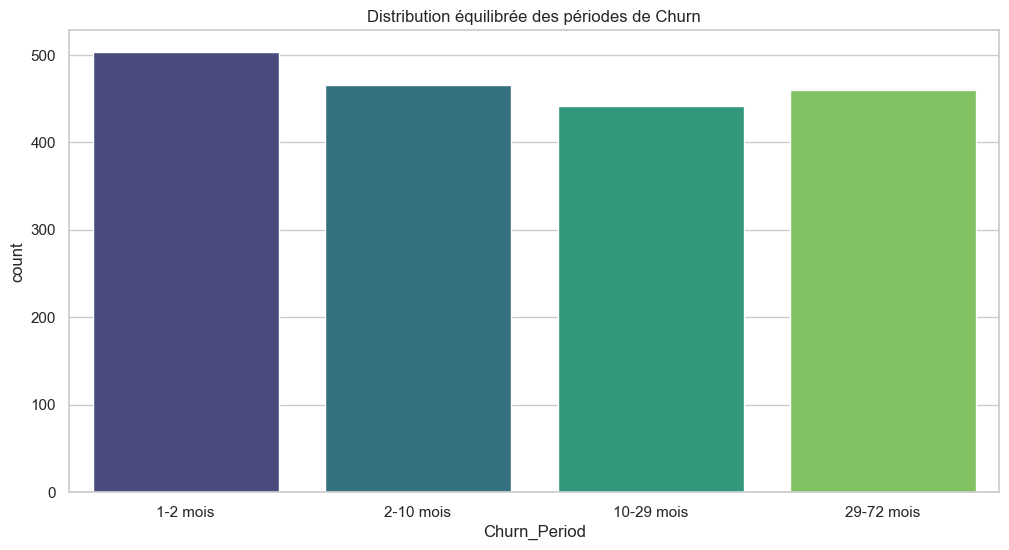

In [113]:


plt.figure(figsize=(12, 6))
# On exclut 'Active' 
sns.countplot(data=df[df['Churn_Period'] != 'Active'], x='Churn_Period', palette='viridis')
plt.title('Distribution équilibrée des périodes de Churn')
plt.show()

C:\Users\sppre\AppData\Local\Temp\ipykernel_13096\3604904538.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Churn_Period', order=ordre, palette=palette)


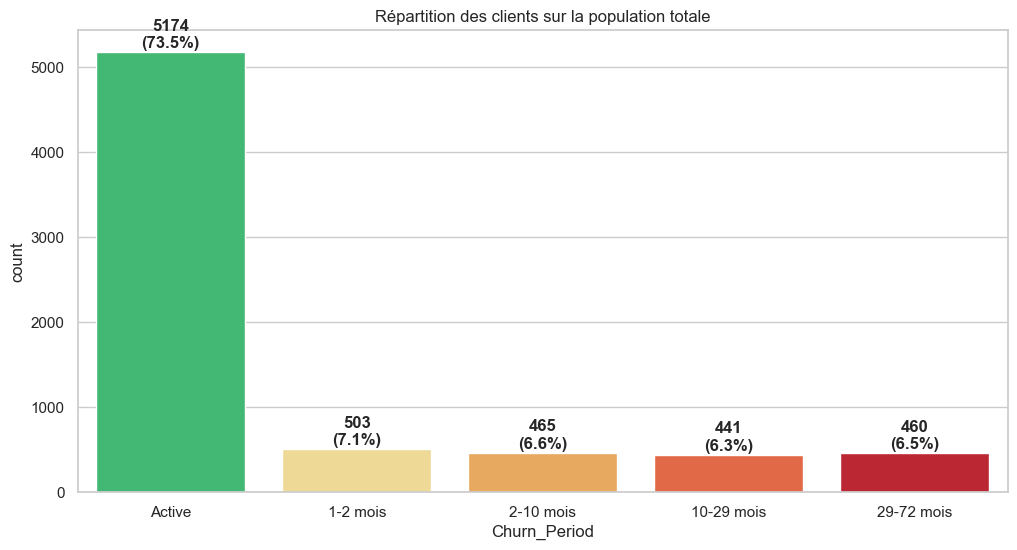

In [114]:
# 4. Visualisation
plt.figure(figsize=(12, 6))
ordre = ['Active'] + labels

palette = ['#2ecc71'] + sns.color_palette("YlOrRd", len(labels))

ax = sns.countplot(data=df, x='Churn_Period', order=ordre, palette=palette)

total = len(df)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}\n({100*p.get_height()/total:.1f}%)', 
                (p.get_x()+0.4, p.get_height()+50), ha='center', fontweight='bold')

plt.title('Répartition des clients sur la population totale')
plt.show()


In [115]:
df

,Unnamed: 0,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,Contract,PaperlessBilling,MonthlyCharges,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Period,Churn_Encoded
0,0,1,0,1,0,1,0,0,1,29.85,...,0,0,0,0,0,0,1,0,Active,0
1,1,0,0,0,0,34,1,1,0,56.95,...,0,0,0,0,0,0,0,1,Active,0
2,2,0,0,0,0,2,1,0,1,53.85,...,0,0,0,0,0,0,0,1,1-2 mois,1
3,3,0,0,0,0,45,0,1,0,42.30,...,1,0,0,0,0,0,0,0,Active,0
4,4,1,0,0,0,2,1,0,1,70.70,...,0,0,0,0,0,0,1,0,1-2 mois,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,7038,0,0,1,1,24,1,1,1,84.80,...,1,0,1,0,1,0,0,1,Active,0
7039,7039,1,0,1,1,72,1,1,1,103.20,...,0,0,1,0,1,1,0,0,Active,0
7040,7040,1,0,1,1,11,0,0,1,29.60,...,0,0,0,0,0,0,1,0,Active,0
7041,7041,0,1,1,0,4,1,0,1,74.40,...,0,0,0,0,0,0,0,1,2-10 mois,2


#  Analyse de la Distribution Temporelle du Churn (Tenure)

## 1. État des Lieux de la Population
L'analyse initiale montre une population majoritairement active (73.5%), mais avec une érosion constante répartie sur plusieurs années.

* **Volume Total d'Actifs :** 5174 clients.
* **Volume Total de Churn :** 1869 clients (répartis sur une période de 0 à 72 mois).

## 2. Analyse de la Variable "Tenure" (Ancienneté)
Avant de segmenter, l'observation des départs par tranches de 3 mois révèle un phénomène critique de **Churn précoce**.

* **Pic de départ :** La tranche 0-3 mois est la plus critique avec 597 départs, soit près de 32% du churn total.
* **Tendance :** Le volume de départ décroît progressivement avec l'ancienneté, confirmant que plus un client reste longtemps, plus sa probabilité de départ immédiat diminue.

## 3. Méthodologie : Création de Tranches Temporelles Équilibrées
Pour transformer ce problème en classification multi-classe efficace, nous avons découpé la variable `tenure` en tranches temporelles. Contrairement à un découpage arbitraire (ex: tous les 12 mois), nous avons opté pour des **tranches de fréquences égales (Quantiles)**.

**Objectif :** Éviter le déséquilibre des classes pour que le modèle apprenne aussi bien à prédire un départ à 2 mois qu'à 48 mois.

### Définition des segments :
* **Segment 1-2 mois :** Churn immédiat (très haute priorité).
* **Segment 2-10 mois :** Churn à court terme.
* **Segment 10-29 mois :** Churn à moyen terme.
* **Segment 29-72 mois :** Churn à long terme (érosion naturelle).

> **Résultat :** Comme illustré par le graphique "Distribution équilibrée", chaque classe de churn comporte désormais environ 450 à 500 individus, offrant une base d'apprentissage saine pour l'algorithme.

---

## 4. Corrélation : Impact du Prix sur la Rapidité du Churn
L'analyse par boxplot montre une corrélation forte entre les charges mensuelles et la rapidité de départ.

* **Churn Précoce (0-12 mois) :** Médiane des prix fluctuante mais avec une grande dispersion.
* **Churn Tardif (42-72 mois) :** On observe une hausse très nette de la médiane des prix (souvent > 100$). 
* **Hypothèse :** Les clients qui restent longtemps finissent par accumuler des services ou subir des augmentations de tarifs, ce qui finit par déclencher leur départ après plusieurs années.

---

## 5. Prochaine Étape : Modélisation
Grâce à cette segmentation équilibrée, nous pouvons maintenant entraîner un modèle (ex: LightGBM) pour répondre à la question : 
**"Dans quelle fenêtre temporelle ce client risque-t-il de partir ?"** plutôt que de simplement prédire s'il partira.